Title

Description

---

Importing packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets
from sklearn.model_selection import GridSearchCV

Select a style sheet for matplotlib

In [2]:
repo = "https://raw.githubusercontent.com/garrettj403/SciencePlots/master"
styleScience = repo + "/styles/science.mplstyle"
styleColor = repo + "/styles/color/bright.mplstyle"
styleGrid = repo + "/styles/misc/grid.mplstyle"
styleNoLatex = repo + "/styles/misc/no-latex.mplstyle"

---

Importing data.

In [3]:
# I use the ipywidgets library to allow for a nice menu to select the dataset.
w_data = widgets.Dropdown(
    options=['Full', 'Spatio-temporal', 'Meteorological', 'Topological'],
    value='Full',
    description='Dataset selection:',
)

print("Choose the dataset you want to use below and you can run the next sections with it.")
display(w_data)

Choose the dataset you want to use below and you can run the next sections with it.


Dropdown(description='Dataset selection:', options=('Full', 'Spatio-temporal', 'Meteorological', 'Topological'…

Import the X and y datasets. If you want to change the dataset you're using, change the selection from the dropdown
above and rerun this cell.

In [73]:
if w_data.value == 'Full':
    X = pd.read_csv(r"data/data_Full_X.csv", index_col=0)
    y = pd.read_csv(r"data/data_Full_y.csv", index_col=0)

elif w_data.value == 'Spatio-temporal':
    X = pd.read_csv(r"data/data_SPT_X.csv", index_col=0)
    y = pd.read_csv(r"data/data_SPT_y.csv", index_col=0)

elif w_data.value == 'Meteorological':
    X = pd.read_csv(r"data/data_M_X.csv", index_col=0)
    y = pd.read_csv(r"data/data_M_y.csv", index_col=0)

elif w_data.value == 'Topological':
    X = pd.read_csv(r"data/data_T_X.csv", index_col=0)
    y = pd.read_csv(r"data/data_T_y.csv", index_col=0)

else: raise Exception("It seems that something went wrong. The widget gave an unexpected output value. "
                      "Values should be one of: ['Full', 'Spatio-temporal', 'Meteorological', 'Topological'].")

print("Features:", list(X.columns))
# print(y.sample(5))

Features: ['elevation', 'Veg Broadleaf Forest', 'Veg Desert', 'Veg Grassland', 'Veg Needleleaf Forest', 'Veg Rock', 'Veg Shrubland']


---

Train-test split the dataset.

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

print(X_train.shape)
print(y_train.shape, "\n")

print(X_test.shape)
print(y_test.shape)

(33522, 7)
(33522, 1) 

(3725, 7)
(3725, 1)


Let's check the balance of the target features by making a bar plot of them.

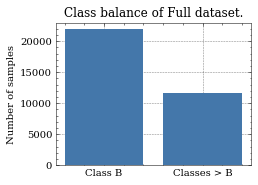

In [8]:
with plt.style.context([styleScience, styleNoLatex, styleColor, styleGrid]):
    plt.bar(x=["Class B", "Classes > B"], height=[(y_train["B"] == 1).sum(), (y_train["B"] == 0).sum()])
    plt.title("Class balance of Full dataset.")
    plt.ylabel("Number of samples")

    if w_data.value == 'Full':
        plt.savefig(r"figures/hist_y_unbalanced.svg")

In order to fix the distribution of the data when training, we want to change it (in the training set only though).

To do this I used a simple random undersample of the training data. I used the imblearn implementation.

In [76]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train, y_train)
# y_train = y_train.values.ravel()

# print(X_train.shape)
# print(y_train.shape)

Let's plot the new distribution.

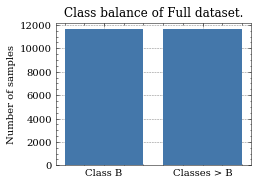

In [13]:
with plt.style.context([styleScience, styleNoLatex, styleColor, styleGrid]):
    plt.bar(x=["Class B", "Classes > B"], height=[(y_train["B"] == 1).sum(), (y_train["B"] == 0).sum()])
    plt.title("Class balance of Full dataset.")
    plt.ylabel("Number of samples")

    if w_data.value == 'Full':
        plt.savefig(r"figures/hist_y_balanced.svg")

Make a correlation matrix of the features.

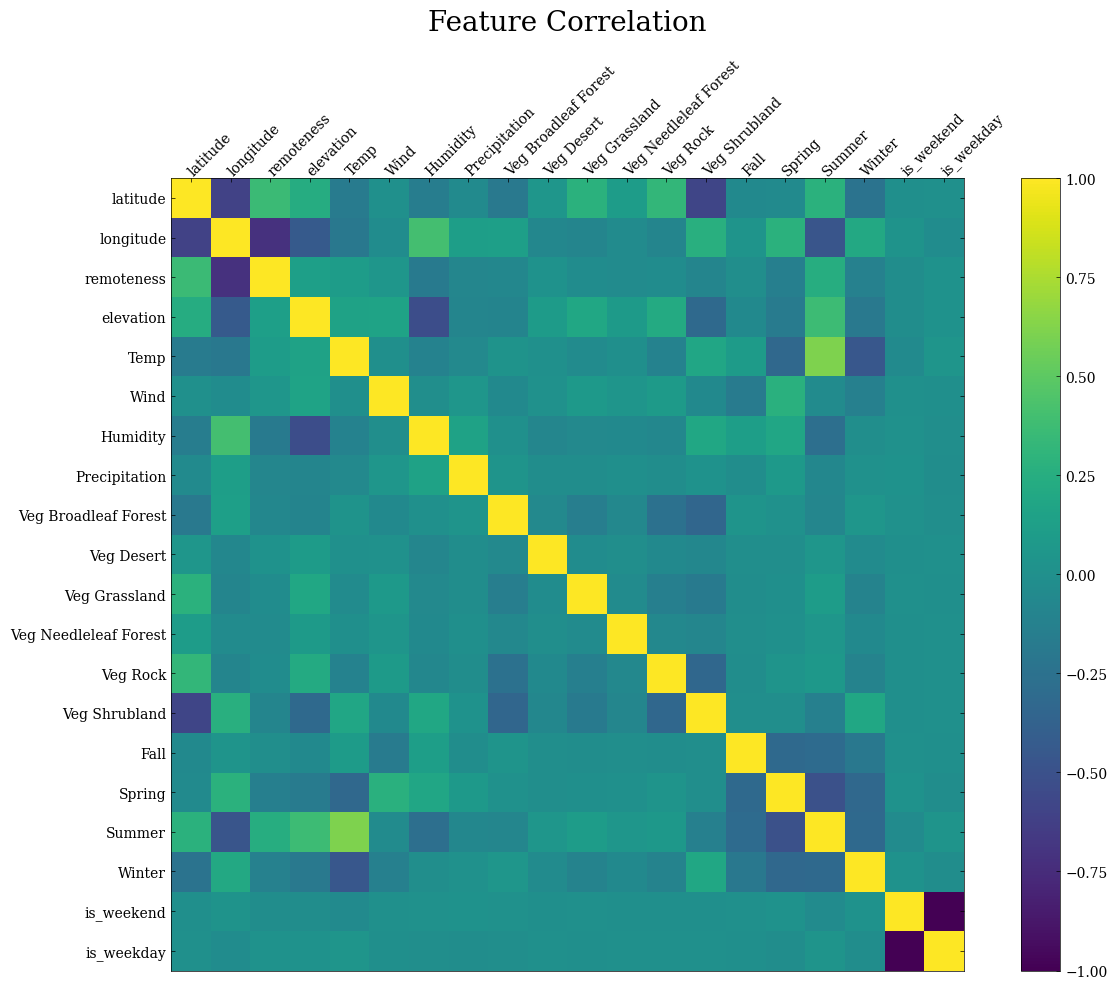

In [53]:
with plt.style.context([styleScience, styleNoLatex, styleColor]):

    plt.rcParams.update({"xtick.minor.visible" : False,
                         "ytick.minor.visible"  : False})

    fig = plt.figure(figsize=[13, 10])
    ax = plt.gca()

    im = ax.matshow(X_train.corr(), interpolation='none')
    fig.colorbar(im)

    ax.set_xticks(range(0, len(X_train.columns)))
    ax.set_xticklabels(list(X_train.columns))
    ax.set_yticks(range(0, len(X_train.columns)))
    ax.set_yticklabels(list(X_train.columns))

    # Set ticks on both sides of axes on
    ax.tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
    # Rotate and align bottom ticklabels
    plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
             ha="right", va="center", rotation_mode="anchor")
    # Rotate and align top ticklabels
    plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
             ha="left", va="center",rotation_mode="anchor")

    ax.set_title("Feature Correlation", size=20, pad=20)
    fig.tight_layout()

    plt.style.use('default')

    if w_data.value == 'Full':
        plt.savefig(r"figures/corrMatrix.svg")

---

Training models, each in a cell

* Dummy classifier
* K-Nearest Neighbour (KNN)
* Naïve Bayes (NB)
* Support Vector Machine (SVM)
* Decision Tree (DT)
* Random Forest (RF)
* Gradient Boosted Trees (GBT)
* Multi-Layered Perceptron (MLP)

Evaluation with confusion matrix, F1 score, etc

### Dummy classifier

In [79]:
from sklearn.dummy import DummyClassifier

param_grid = {'strategy': ['stratified']}

grid_searchDummy = GridSearchCV(DummyClassifier(), param_grid, cv=10, n_jobs=-1)
grid_searchDummy.fit(X_train, y_train)

training_accuracy = grid_searchDummy.score(X_train, y_train)
test_accuracy = grid_searchDummy.score(X_test, y_test)

print("Test set score: {}".format(grid_searchDummy.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchDummy.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.5041610738255033
Results on the test set:
              precision    recall  f1-score   support

           0       0.34      0.48      0.39      1291
           1       0.64      0.50      0.56      2434

    accuracy                           0.49      3725
   macro avg       0.49      0.49      0.48      3725
weighted avg       0.54      0.49      0.50      3725



### KNN

In [80]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': range(2, 30, 2), 'weights': ['uniform', 'distance']}

grid_searchKNN = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, n_jobs=-1)
grid_searchKNN.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchKNN.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchKNN.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.6195973154362416
Results on the test set:
              precision    recall  f1-score   support

           0       0.46      0.58      0.51      1291
           1       0.74      0.64      0.69      2434

    accuracy                           0.62      3725
   macro avg       0.60      0.61      0.60      3725
weighted avg       0.64      0.62      0.63      3725



### Naive Bayes

In [81]:
from sklearn.naive_bayes import GaussianNB

param_grid = {}

grid_searchGNB = GridSearchCV(GaussianNB(), param_grid, cv=10, n_jobs=-1)
grid_searchGNB.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchGNB.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchGNB.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.6510067114093959
Results on the test set:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43      1291
           1       0.71      0.80      0.75      2434

    accuracy                           0.65      3725
   macro avg       0.60      0.59      0.59      3725
weighted avg       0.63      0.65      0.64      3725



### Support Vector Machine

In [82]:
from sklearn.svm import SVC

param_grid = {'kernel': ['poly', 'rbf', 'sigmoid'],'C': [0.01, 0.1, 0.25, 0.5, 1, 2]}

grid_searchSVC = GridSearchCV(SVC(), param_grid, cv=10, n_jobs=-1)
grid_searchSVC.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchSVC.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchSVC.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.6681879194630872
Results on the test set:
              precision    recall  f1-score   support

           0       0.53      0.38      0.44      1291
           1       0.71      0.82      0.76      2434

    accuracy                           0.67      3725
   macro avg       0.62      0.60      0.60      3725
weighted avg       0.65      0.67      0.65      3725



### Decision Tree

In [83]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth': [2, 4, 16, 64, 128, 256, None], 'criterion': ['gini', 'entropy']}

grid_searchDT = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, n_jobs=-1)
grid_searchDT.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchDT.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchDT.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.6448322147651007
Results on the test set:
              precision    recall  f1-score   support

           0       0.49      0.50      0.49      1291
           1       0.73      0.72      0.73      2434

    accuracy                           0.64      3725
   macro avg       0.61      0.61      0.61      3725
weighted avg       0.65      0.64      0.65      3725



### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': [2, 4, 16, 64, 128, 256, None], 'n_estimators': [100, 500, 1000], 'criterion': ['gini', 'entropy']}

rf_cl = RandomForestClassifier()

grid_searchRF = GridSearchCV(rf_cl, param_grid, cv=10, n_jobs=-1)
grid_searchRF.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchRF.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchRF.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Let's make a feature importance plot.

In [ ]:
# based on mean decrease in impurity
importances = grid_searchRF.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in grid_searchRF.best_estimator_.estimators_], axis=0)

forestImportances = pd.Series(importances, index=X_train.columns)


# make the plot
with plt.style.context([styleScience, styleNoLatex, styleColor, styleGrid]):
    fig, ax = plt.subplots()
    forestImportances.plot.bar(yerr=std, ax=ax, fontsize=7)

    ax.set_ylabel("Mean decrease in impurity")

    plt.savefig(fr"figures/{w_data.value}_featureImportance.svg")


### Gradient Boosted Trees (GBT)

In [86]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = {'max_depth':[2,4,8,16,32,64,None], 'max_iter':[10, 50, 100, 250, 500, 1000, 2500]}

grid_searchGBT = GridSearchCV(HistGradientBoostingClassifier(), param_grid, cv=10, n_jobs=-1)
grid_searchGBT.fit(X_train, y_train)

print("Best parameters: {}".format(grid_searchGBT.best_params_))
print("Test set score: {}".format(grid_searchGBT.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchGBT.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Best parameters: {'max_depth': None, 'max_iter': 2500}
Test set score: 0.6695302013422819
Results on the test set:
              precision    recall  f1-score   support

           0       0.53      0.48      0.50      1291
           1       0.74      0.77      0.75      2434

    accuracy                           0.67      3725
   macro avg       0.63      0.62      0.63      3725
weighted avg       0.66      0.67      0.67      3725



### Multi-Layered Perceptron (MLP)

In [87]:
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(5), (50), (100), (250), (1000), (10, 10), (25, 25), (50, 50), (100, 100), (250, 250)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant']
}

grid_searchMLP = GridSearchCV(MLPClassifier(max_iter=10000), param_grid, cv=10, n_jobs=-1)

grid_searchMLP.fit(X_train, y_train)

print("Test set score: {}".format(grid_searchMLP.score(X_test, y_test)))

y_true, y_pred = y_test , grid_searchMLP.predict(X_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Test set score: 0.6649664429530201
Results on the test set:
              precision    recall  f1-score   support

           0       0.52      0.46      0.49      1291
           1       0.73      0.77      0.75      2434

    accuracy                           0.66      3725
   macro avg       0.62      0.62      0.62      3725
weighted avg       0.66      0.66      0.66      3725



---

Getting the final results (nicely formatted).

I wrote a function that does this since I couldn't find anything suitable online. Also saves it in a .csv file.

In [61]:
import re
from sklearn.metrics import precision_recall_fscore_support


def getResults(algoList, verbose=True, save=False):
    """
    :param algoList: List of gridSearch-class objects you want to get the results for
    :param verbose: If true prints the final Pandas dataframe
    :param save: If true saves the file as a .csv file in '/results/{dataset name}_results.csv'
    :return:
    """
    beforeParenthesis = re.compile("(.*?)\s*\(")

    dfResults = pd.DataFrame(columns=['Classifier', 'Parameters', 'Accuracy', 'Precision', 'Recall',
                                      'F1-Score', 'CV Splits', 'Training time'])
    for algo in algoList:
        tempList = []

        classifier = beforeParenthesis.match(str(algo.best_estimator_)).group(1)
        tempList.append(classifier)

        parameters = list(algo.best_params_.items())
        tempList.append(parameters)

        accuracy = algo.best_score_
        tempList.append(accuracy)

        y_true, y_pred = y_test, algo.predict(X_test)
        precision, recall, fScore, support = precision_recall_fscore_support(y_true, y_pred, average='macro')
        tempList.append(precision)
        tempList.append(recall)
        tempList.append(fScore)

        splits = algo.n_splits_
        tempList.append(splits)

        trainTime = algo.refit_time_
        tempList.append(trainTime)

        dfResults.loc[len(dfResults)] = tempList

    if save:
        dfResults.to_csv(fr'results/{w_data.value}_results.csv')

    if verbose:
        print(dfResults)

Now we call the function.

In [88]:
algoList = [grid_searchDummy, grid_searchKNN, grid_searchGNB, grid_searchSVC,
            grid_searchDT, grid_searchRF, grid_searchGBT, grid_searchMLP]

getResults(algoList, verbose=False, save=True)


                       Classifier  \
0                 DummyClassifier   
1            KNeighborsClassifier   
2                      GaussianNB   
3                             SVC   
4          DecisionTreeClassifier   
5          RandomForestClassifier   
6  HistGradientBoostingClassifier   
7                   MLPClassifier   

                                          Parameters  Accuracy  Precision  \
0                           [(strategy, stratified)]  0.493717   0.489809   
1           [(n_neighbors, 28), (weights, distance)]  0.598253   0.601201   
2                                                 []  0.575529   0.601183   
3                            [(C, 2), (kernel, rbf)]  0.596059   0.622008   
4                [(criterion, gini), (max_depth, 4)]  0.596748   0.609533   
5  [(criterion, entropy), (max_depth, 16), (n_est...  0.605742   0.616225   
6              [(max_depth, None), (max_iter, 2500)]  0.606646   0.630461   
7  [(activation, relu), (alpha, 0.0001), (hidden_.